In [1]:
import warnings
warnings.simplefilter('ignore')

import pandas as pd
import numpy as np

%matplotlib inline 
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.figsize'] = (16, 10)

from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error

from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor

<h3>1. Считываем данные по продажам какого-то товара магазина и соответствующим акциям</h3>

In [2]:
df = pd.read_excel('./data/shop.xls', header=None)

<h3>2. Форматируем данные</h3>

In [3]:
df[2] = df[2].replace(' ', 0).astype('float64')

In [4]:
df.rename(columns = {
    0: 'date',
    1: 'sales',
    2: 'discount'
}, inplace=True);

In [5]:
df.head()

,date,sales,discount
0,01.09.2015,95.84,29.33
1,02.09.2015,84.40,29.33
2,03.09.2015,103.60,29.33
3,04.09.2015,146.24,29.33
4,05.09.2015,124.48,29.33


<h3>3. Подготавливаем тренировочные и тестовые данные для предсказания продаж как функции (Time series prediction)</h3>
<h4>Суть метода:</h4>
<p>Рассматриваем продажи как функцию. В качестве входных данных берем $k$ значений функции, в качестве выходных данных хотим предсказать $k+1$ значение функции. Если функция периодическая, то этот метод должен давать неплохие результаты.</p>

In [6]:
y = df['sales']

In [7]:
train_size = int(len(y) * 0.8)
test_size = int(len(y) - train_size)
train, test = y[0:train_size], y[train_size:len(y)]

In [8]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [9]:
look_back = 5
trainX, trainY = create_dataset(train.reshape(-1, 1), look_back)
testX, testY = create_dataset(test.reshape(-1, 1), look_back)

<p>Добавляем информацию об акции в интересующий нас день</p>

In [10]:
trainX = np.c_[trainX, df['discount'][look_back:train_size]]

In [11]:
testX = np.c_[testX, df['discount'][train_size + look_back:len(y)]]

<h3>4. Обучаем модель, используя разные алгоритмы</h3>

In [12]:
knn_pipe = Pipeline([('scaler', StandardScaler()), ('knn', KNeighborsRegressor(n_jobs=-1))])
knn_params = {'knn__n_neighbors': range(1, 30)}

model = GridSearchCV(knn_pipe, knn_params, cv=5, n_jobs=-1)
model.fit(trainX, trainY)
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

print("kNN(train) mse =", mean_squared_error(trainY, trainPredict))
print("kNN(test) mse =", mean_squared_error(testY, testPredict))

kNN(train) mse = 3041.73644172
kNN(test) mse = 3047.72530515


In [13]:
tree_params = {'max_depth': range(1,30), 'min_samples_leaf': range(1,30)}

model = GridSearchCV(DecisionTreeRegressor(), tree_params, cv=5, n_jobs=-1)
model.fit(trainX, trainY)
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

print("tree(train) mse =", mean_squared_error(trainY, trainPredict))
print("tree(test) mse =", mean_squared_error(testY, testPredict))
print(model.best_params_)

tree(train) mse = 3096.52815227
tree(test) mse = 2494.53961152
{'max_depth': 4, 'min_samples_leaf': 23}


In [15]:
scaler = StandardScaler()
scaler.fit(trainX)
X_train_norm = scaler.transform(trainX)
X_cv_norm = scaler.transform(testX)

model = MLPRegressor(hidden_layer_sizes=(1000, 1000))
model.fit(X_train_norm, trainY)
trainPredict = model.predict(X_train_norm)
testPredict = model.predict(X_cv_norm)

print("MLPRegressor(train) mse =", mean_squared_error(trainY, trainPredict))
print("MLPRegressor(test) mse =", mean_squared_error(testY, testPredict))

MLPRegressor(train) mse = 9741.19105057
MLPRegressor(test) mse = 7346.65329779


In [20]:
model = LinearRegression()
model.fit(trainX, trainY)
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

print("LinearRegression(train) mse =", mean_squared_error(trainY, trainPredict))
print("LinearRegression(test) mse =", mean_squared_error(testY, testPredict))

LinearRegression(train) mse = 1490.64496503
LinearRegression(test) mse = 1101.61442791


<h3>5. Визуализируем результаты</h3>
<h4>На графике:</h4>
<ul>
<li>синим цветом - реальный график продаж</li>
<li>оранжевым - предсказания на тренировочной выборке</li>
<li>зеленым - предсказания на тестовой выборке</li>
</ul>

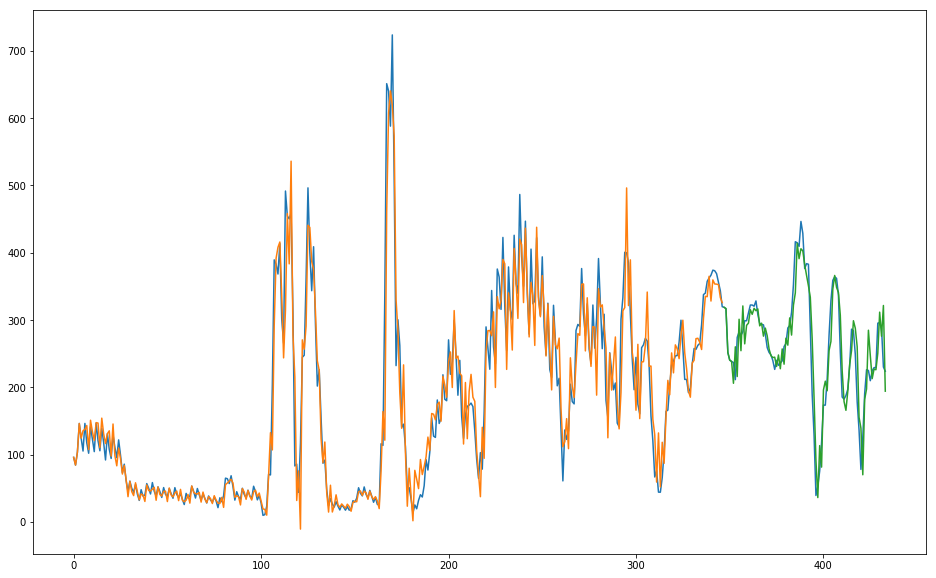

In [21]:
plt.plot(y);

y_train_pred = np.r_[y[0:look_back], trainPredict]
plt.plot(np.arange(train_size), y_train_pred);
y_test_pred = np.r_[y[train_size: train_size + look_back], testPredict]
plt.plot(np.arange(train_size, train_size + test_size), y_test_pred);

<h3>6. Выводим результаты предсказаний в файл $res.xls$</h3>

In [22]:
res = np.r_[y[0:look_back], trainPredict, y[train_size: train_size + look_back], testPredict]

sales = np.array(y)
writer = pd.ExcelWriter('res.xls')
res_df = pd.DataFrame({
    'sales': sales, 'sales_pred': res
})
res_df.to_excel(writer, sheet_name='Sheet1')
writer.save()